# Text classification and hyperparameter optimization

In [1]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

<br><br>

## Introduction <a name="in"></a>
<hr>

In this notebook, I want to focus on two things:
1. Working with text data
2. Hyperparameter optimization  

## Step 1: Introducing the dataset and EDA <a name="1"></a>
<hr>

I am going to develop an SMS spam classification system using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The prediction problem here is predicting whether a given text message is spam or not spam.  

Download the CSV and save it as `spam.csv` locally in this lab folder. 

> **Some text messages contain offensive language. Unfortunately, it's the reality of such platforms 😔. ** 


In [2]:
sms_df = pd.read_csv("spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [3]:
sms_df.shape

(5572, 2)

### 1.1 Data splitting  

In [4]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends ...
1283,ham,Yes i thought so. Thanks.
2327,spam,URGENT! Your mobile number *************** WON...
1103,ham,Aiyah sorry lor... I watch tv watch until i fo...


<br><br>

### 1.2 Simple EDA 

In [5]:
train_df["target"].value_counts()

ham     3843
spam     614
Name: target, dtype: int64

In [6]:
sorted_df = train_df.reindex(train_df.sms.str.len().sort_values().index)
print(
    "Average length of text messages in number of characters: %0.3f"
    % (train_df.sms.str.len().mean())
)
print("Shortest sms: %s\n" % (sorted_df.iloc[0]["sms"]))
print("Longest sms: %s\n" % (sorted_df.iloc[-1]["sms"]))

Average length of text messages in number of characters: 80.284
Shortest sms: Ok

Longest sms: The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.



<br><br>

> It does not make sense to apply OHE here because there are no fixed categories in this column, each value is going to be different and fairly unique. It's a free text column and bag-of-words encoding makes more sense. 

<br><br>

### 1.3 Word clouds

Here I create two word clouds: one for text messages with `spam` target and one for text messages with `ham` target (non-spam messages). I am using [the `wordcloud` package](https://github.com/amueller/word_cloud) for this.

In [7]:
spam_messages = " ".join(train_df[train_df["target"] == "spam"]["sms"].tolist())
ham_messages = " ".join(train_df[train_df["target"] == "ham"]["sms"].tolist())

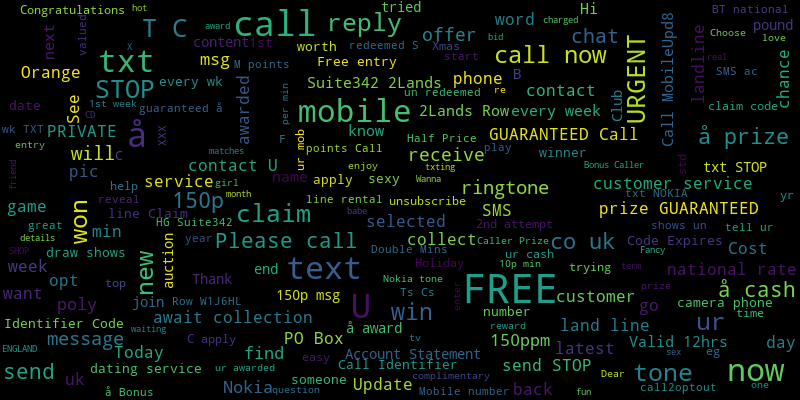

In [8]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(spam_messages).to_image()

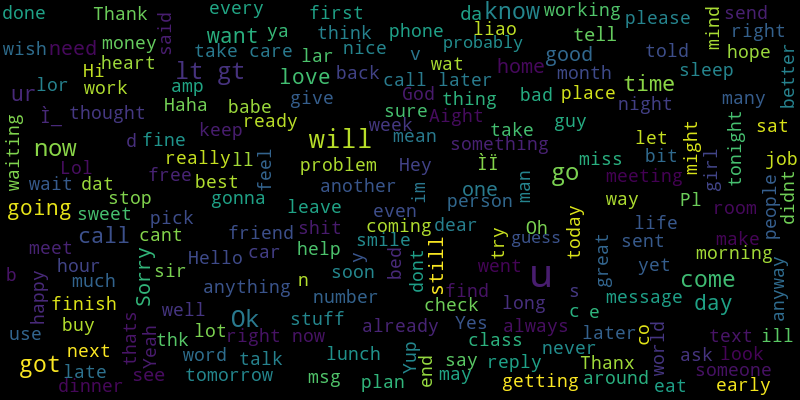

In [9]:
wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(ham_messages).to_image()

<br><br><br><br>

## Step 2: Exploring `CountVectorizer` <a name="2"></a>
<hr>

I am encoding the text data using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

### 2.1 `CountVectorizer` with default parameters or with `stop_words='english'`

> Note that unlike other transformers, you pass a `pandas.Series` object or a 1-D array to `CountVectorizer`. 

In [10]:
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]

In [11]:
vec = CountVectorizer()
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
print("%d total number of features " % (len(vec.vocabulary_)))

7682 total number of features 


In [12]:
transformed_X_train.shape

(4457, 7682)

For comparison, now create a `CountVectorizer` with `stop_words='english'` and transform the training data. 

In [13]:
vec = CountVectorizer(stop_words="english")
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
print("%d total number of features " % (len(vec.vocabulary_)))

7419 total number of features 


In [14]:
transformed_X_train.shape

(4457, 7419)

The dimensionality is different because now I am ignoring stop words. 

<br><br>

### 2.2 `max_features` 

Here I pass the following two arguments to `CountVectorizer` and transform the training data again. 
    - `max_features=1000`
    - `stop_words=english` 

In [15]:
vec = CountVectorizer(max_features=1000, stop_words="english")
vec.fit(X_train, y_train)
transformed_X_train = vec.transform(X_train)
transformed_X_train.shape

(4457, 1000)

<br><br>

### 2.3 Visualizing the transformed data

Here I want to examine some features (words) created by `CountVectorizer`.

To be specific, I visualize the transformed data as a pandas dataframe by only including the columns below (assuming they are present in the vocabulary). 
    - 'free'
    - 'love'
    - 'prize'
    - 'urgent'

In [16]:
vocab = vec.get_feature_names_out()

In [17]:
vocab[0:10]

array(['00', '000', '03', '04', '06', '0800', '08000839402',
       '08000930705', '0870', '10'], dtype=object)

In [18]:
vocab[0::30]

array(['00', '2day', 'ago', 'awesome', 'break', 'changed', 'comp', 'cup',
       'die', 'dude', 'fancy', 'friend', 'gonna', 'head', 'huh', 'joined',
       'leh', 'loved', 'meh', 'motorola', 'nt', 'park', 'police', 'read',
       'run', 'set', 'smth', 'style', 'thanx', 'tot', 'use', 'water',
       'wondering', 'yest'], dtype=object)

In [19]:
"free" in vocab

True

In [20]:
df = pd.DataFrame(
    transformed_X_train.toarray(), columns=vocab.tolist(), index=X_train.index
)

In [21]:
df.loc[:, ["free", "love", "prize", "urgent"]]

,free,love,prize,urgent
385,0,0,0,0
4003,0,0,0,0
1283,0,0,0,0
2327,0,0,1,1
1103,0,0,0,0
...,...,...,...,...
5218,0,0,0,0
4060,1,0,0,0
1346,0,0,0,0
3454,0,0,0,0


In [22]:
print(train_df.loc[1742]["sms"])

\EY! CALM DOWNON THEACUSATIONS.. ITXT U COS IWANA KNOW WOTU R DOIN AT THEW/END... HAVENTCN U IN AGES..RING ME IF UR UP4 NETHING SAT.LOVE J XXX.\""


If we transform a random message `ex_msg` given below using the `CountVectorizer` from aboce, we get only 1 non-zero elements in the bag-of-words representation of this message.

In [23]:
ex_msg = "I am learning many new topics in MDS."

We are likely to underfit with less number of features. More features means more complex model and less features means less complex model. 

In [24]:
transformed = vec.transform([ex_msg])

In [25]:
np.count_nonzero(transformed.toarray())

1

This means when we encounter a word in test data that's not present in `max_features`, the word will be just ignored. 

<br><br><br><br>

## Step 3: Model building <a name="3"></a>
<hr>

## 3.1 `DummyClassifier`

I am going to start with a baseline model. 

In [26]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

pd.DataFrame(scores).mean()

fit_time       0.001339
score_time     0.001060
test_score     0.862239
train_score    0.862239
dtype: float64

The baseline for this model is quite high. This is because the distribution of the target is quite skewed; we have many examples of non-spam (ham) and relatively less examples of spam. 

<br><br>

### 3.2 `SVC` with default parameters

Build a pipeline for feature extraction using `CountVectorizer` with `stop_words='english'` and `SVC` with default hyperparameters.


In [27]:
svc_pipe = make_pipeline(CountVectorizer(stop_words="english"), SVC())
scores = cross_validate(svc_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.359206
score_time     0.076075
test_score     0.977113
train_score    0.994840
dtype: float64

SVC with default parameters is giving us better scores than the dummy classifier. 

<br><br><br><br>

## Step 4: Hyperparameter optimization <a name="4"></a>
<hr>

Compared with writing loops to try a bunch of different hyperparameter values and pick the one with lowest cross-validation error, `scikit-learn` has some [built-in methods](https://scikit-learn.org/stable/modules/grid_search.html) to make life easier. 

1. [`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 
2. [`sklearn.model_selection.RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

### 4.1 Optimizing `C` for SVM RBF

1. Carry out hyperparameter search over `C` by sweeping the hyperparameter through the values $10^{-3}, \ldots, 10^{-1}, 1, \ldots, 10^{3}$ using [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and 10-fold cross-validation.
2. Plot training and cross-validation curves (mean train and mean cross-validation scores for different values of `C` from the `param_grid`) with `C` on the x-axis and scores on the y-axis. 
3. Summarize the best hyperparameter value and the corresponding best cross-validation score.

A few tips about `GridSearchCV`: 

- We have two steps in our pipeline and we can access the parameters of these steps using `__` to go deeper. So `svc__C` means `C` of `svc` step of the pipeline. 
- Setting `n_jobs=-1` should speed things up (if you have a multi-core processor).
- Similar to `cross_validate`, you can pass `return_train_score=True` to your `GridSearchCV` object.
- By default, after carrying out the search, `GridSearchCV` also refits a model with the entire training set with the best hyperparameter values. 

In [28]:
param_grid = {"svc__C": 10.0 ** np.arange(-3, 4)}

In [29]:
import matplotlib.pyplot as plt
def plot_train_cv(param_vals, train_scores, cv_scores, xlabel, ylabel="accuracy"):
    plt.semilogx(param_vals, train_scores, label="train")
    plt.semilogx(param_vals, cv_scores, label="valid")
    plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [30]:
print(
    "We are carrying out %d 10-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

C_search = GridSearchCV(
    svc_pipe, param_grid, n_jobs=-1, cv=10, return_train_score=True
)
C_search.fit(X_train, y_train)
print("Best hyperparameter values: ", C_search.best_params_)
print("Best score: %0.3f" % (C_search.best_score_))

We are carrying out 7 10-fold cross-validation experiments
Best hyperparameter values:  {'svc__C': 10.0}
Best score: 0.981


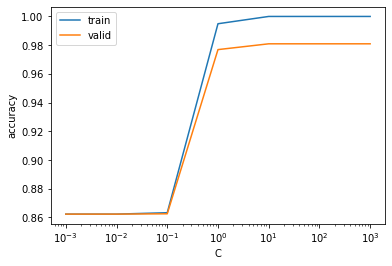

In [31]:
train_scores = C_search.cv_results_["mean_train_score"]
cv_scores = C_search.cv_results_["mean_test_score"]
plot_train_cv(param_grid["svc__C"], train_scores, cv_scores, xlabel="C")

We see that for larger values of `C` the training score goes up. The gap between train and validation is not changing much after `C=1`. 

We see some improvement after hyperparameter optimization of `C` with `C=10`. 

<br><br>

### 4.2 Jointly optimizing `C` and `gamma`

Expand my search to cover the `gamma` hyperparameter in addition to `C`, sweeping the hyperparameter through values $10^{-3}, 10^{-2}, \ldots, 10^{3}$. Use the same `C` values from above. 

In [32]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-3, 4),
    "svc__C": 10.0 ** np.arange(-3, 4),
}
print(
    "We are carrying out %d 10-fold cross-validation experiments"
    % (np.prod(list(map(len, param_grid.values()))))
)

gamma_search = GridSearchCV(
    svc_pipe, param_grid, n_jobs=-1, return_train_score=True
)
gamma_search.fit(X_train, y_train)
print("Best hyperparameter values: ", gamma_search.best_params_)
print("Best score: %0.3f" % (gamma_search.best_score_))

We are carrying out 49 10-fold cross-validation experiments
Best hyperparameter values:  {'svc__C': 1000.0, 'svc__gamma': 0.001}
Best score: 0.983


Here I get a different value of `C` in both cases, which makes sense. A joint search over a $n$-dimensional parameter space may yield a different optimum than searching over any of those parameters individually. 

However, on a side note, I am trying more models now, so optimization bias can increase. 

<br><br>

### 4.3 Optimizing `C` and `gamma` of SVM RBF and `binary` and `max_features` of `CountVectorizer` jointly with `RandomizedSearchCV`


Similar to estimators, transformers also have hyperparameters. 
Now that I have tried manual grid search, here I jointly optimize hyperparameters of `SVC` as well as `CountVectorizer` using 
`RandomizedSearchCV`, which, as its name implies, tries random hyperparameter configurations instead of performing an exhaustive grid search. 

Reference: [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). 


In [33]:
random_search = None

In [34]:
param_grid = {
    "svc__C": 10.0 ** np.arange(-3, 3),
    "svc__gamma": 10.0 ** np.arange(-3, 3),
    "countvectorizer__max_features": [10, 100, 1000, 4000, 8000],
    "countvectorizer__binary": [True, False],
}

In [35]:
random_search = RandomizedSearchCV(
    svc_pipe,
    param_grid,
    n_iter=200,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)

random_search.fit(X_train, y_train);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [36]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_svc__C",
        "param_countvectorizer__max_features",
        "param_countvectorizer__binary",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

Best hyperparameter values:  {'svc__gamma': 0.1, 'svc__C': 10.0, 'countvectorizer__max_features': 4000, 'countvectorizer__binary': True}
Best score: 0.983


rank_test_score,1,2,3,4,5,6,7,8,9,10,...,109,109,109,109,109,109,109,109,109,109
mean_train_score,0.999832,0.999888,0.999888,0.994447,1.0,0.994503,1.0,0.988557,1.0,0.990072,...,0.862239,0.8628,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239
mean_test_score,0.983395,0.98317,0.982721,0.982497,0.982273,0.981375,0.981374,0.980927,0.980703,0.980702,...,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239,0.862239
param_svc__C,10.0,100.0,100.0,100.0,10.0,10.0,100.0,100.0,100.0,1.0,...,0.1,0.1,0.1,0.01,0.01,0.01,0.001,0.001,0.001,0.01
param_countvectorizer__max_features,4000,4000,4000,4000,8000,4000,8000,1000,8000,1000,...,10,100,8000,100,8000,1000,8000,8000,4000,8000
param_countvectorizer__binary,True,False,False,False,True,False,False,True,True,False,...,True,False,False,False,False,True,False,True,True,False
mean_fit_time,0.532637,0.261878,0.540232,0.25845,0.549105,0.277511,0.352144,0.195522,0.325834,0.328751,...,0.143596,0.376233,0.993505,0.358729,0.880197,0.318767,0.475016,0.382326,0.408718,0.793415


`GridSearchCV` can be slow and computationally intensive when the search space is large, as it tries out every possible combination of the values and measures the model performance for that configuration. 

Also, when there are some unimportant hyperparameters in the grid, it wastes many searches while systematically sweeping through this unimportant hyperparameter. 

An approach like `RandomizedSearchCV` is preferable in such scenarios, as it tries out a given number of trails from the search space at random. Because of its random nature, it explores more parts of the search space and is less likely to waste searches caused by systematically sweeping over unimportant hyperparameters. 

<br><br>

### 4.4: Notes about more sophisticated hyperparameter tuning. 

There are all sorts of software packages that make hyperparameter tuning with `scikit-learn` even more automated. For example:

- [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
- [auto-sklearn](https://github.com/automl/auto-sklearn)
- [SigOptSearchCV](https://sigopt.com/docs/overview/scikit_learn)

Apart from that, there are also packages that aren't tied to `scikit-learn`. I list them here as references:

- [TPOT](https://github.com/rhiever/tpot)
- [hyperopt](https://github.com/hyperopt/hyperopt)
- [hyperband](https://github.com/zygmuntz/hyperband)
- [SMAC](http://www.cs.ubc.ca/labs/beta/Projects/SMAC/)
- [MOE](https://github.com/Yelp/MOE)
- [pybo](https://github.com/mwhoffman/pybo)
- [spearmint](https://github.com/HIPS/Spearmint)
- [BayesOpt](https://github.com/rmcantin/bayesopt)

> This list isn't meant to be exhaustive. 

In other news, the recently announced [Amazon SageMaker](https://aws.amazon.com/sagemaker/) is also supposed to do hyperparameter optimization (among many other things it does).

<br><br><br><br>

## Step 5: Test results <a name="5"></a>
<hr>

In [37]:
print("CV score: %0.3f" % (random_search.best_score_))
print("Train score: %0.3f" % (random_search.score(X_train, y_train)))
print("Test score: %0.3f" % (random_search.score(X_test, y_test)))

CV score: 0.983
Train score: 1.000
Test score: 0.985


Now I try the best model on a couple of spam and ham (non-spam) text messages from my inbox.

In [38]:
sample_text_msgs = ['Good morning!', "Call 8375467843 immediately. You have a free gift waiting for you ..."
]

In [39]:
random_search.predict(sample_text_msgs)

array(['ham', 'ham'], dtype=object)

The test scores are consistent with the validation scores. So our cross-validation results seem representative of the test data and the model doesn't seem to overfit. I don't believe that we have a close to perfect and a reliable system for spam identification. Our dataset is rather small and the `most_frequent` baseline for the dataset is pretty high. More rigorous evaluation, probably on some data in the wild, would give us a better picture. 

<br><br><br><br>